## Setup

In [51]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.dates as mdates
from statsforecast.core import StatsForecast
from statsmodels.tsa.seasonal import seasonal_decompose
from statsforecast.models import Naive, SeasonalNaive
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# GOLD_PATH = '/home/lucas-nunes/workspace/Postech/challenges/2_ibov/data/gold'

# GOLD_PATH = "./"

GOLD_PATH = r"E:\PosGraducacao\fase_2_machine_learning_and_time_series\tech_challenge\Postech\challenges\2_ibov\data\gold"

PERIOD_SEAZONAL_NAIVE_WEEKLY = 7
PERIOD_SEAZONAL_NAIVE_MONTHLY = 30
PREDICTION_DAYS = 90

MIN_THRESHOLD_VALID = 0.70 # Value should be at least this value to be considered on the Model

LIST_COLUMNS_DF_FILTER = ['data', 'ultimo']

## Read

In [52]:
df = pd.read_parquet(f'{GOLD_PATH}/gold.parquet')
list_value_columns = df.columns.to_list()
list_value_columns.remove('data')
list_value_columns.remove('ibov')
list_value_columns.remove('ibov_futuro')
list_value_columns.insert(len(list_value_columns), 'ibov_futuro')
list_value_columns.insert(len(list_value_columns), 'ibov')
list_value_columns

['prata',
 'us30',
 'ouro',
 'spx',
 'ndx',
 'petroleo',
 'vix',
 'eur_brl',
 'usd_brl',
 'ibrx100',
 'BBSA3',
 'CPLE6',
 'ITUB4',
 'VALE3',
 'PETR3',
 'ELET3',
 'ibrx50',
 'FTXIN9',
 'RENT3',
 'us500',
 'SLCE3',
 'cobre',
 'FLRY3',
 'bitcoin',
 'ferro',
 'MGLU3',
 'STOXX50E',
 'ethereum',
 'CRFB3',
 'ibov_futuro',
 'ibov']

## Correlations

In [53]:
df_2k = df.where(df['data'] > datetime.date(2000, 1, 1)).dropna(how='all')

In [54]:
correlation_matrix = df[list_value_columns].corr()
correlation_matrix_only_ibov = df[list_value_columns].corr()[['ibov']].sort_values(by='ibov')
correlation_matrix_2k = df_2k[list_value_columns].corr()

In [55]:
list_index_within_threshold = [key for key, value in correlation_matrix['ibov'].to_dict().items() if value > MIN_THRESHOLD_VALID]

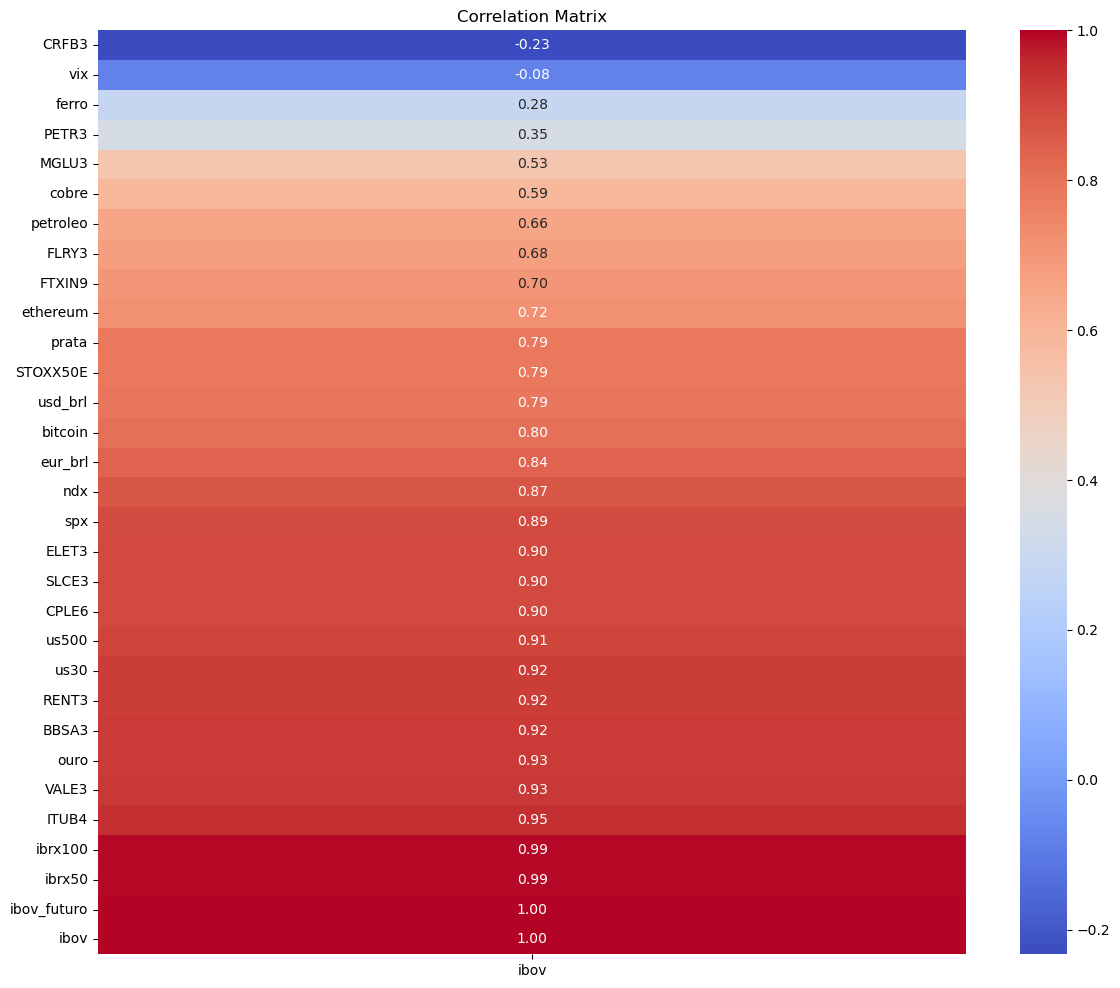

In [56]:
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_only_ibov, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

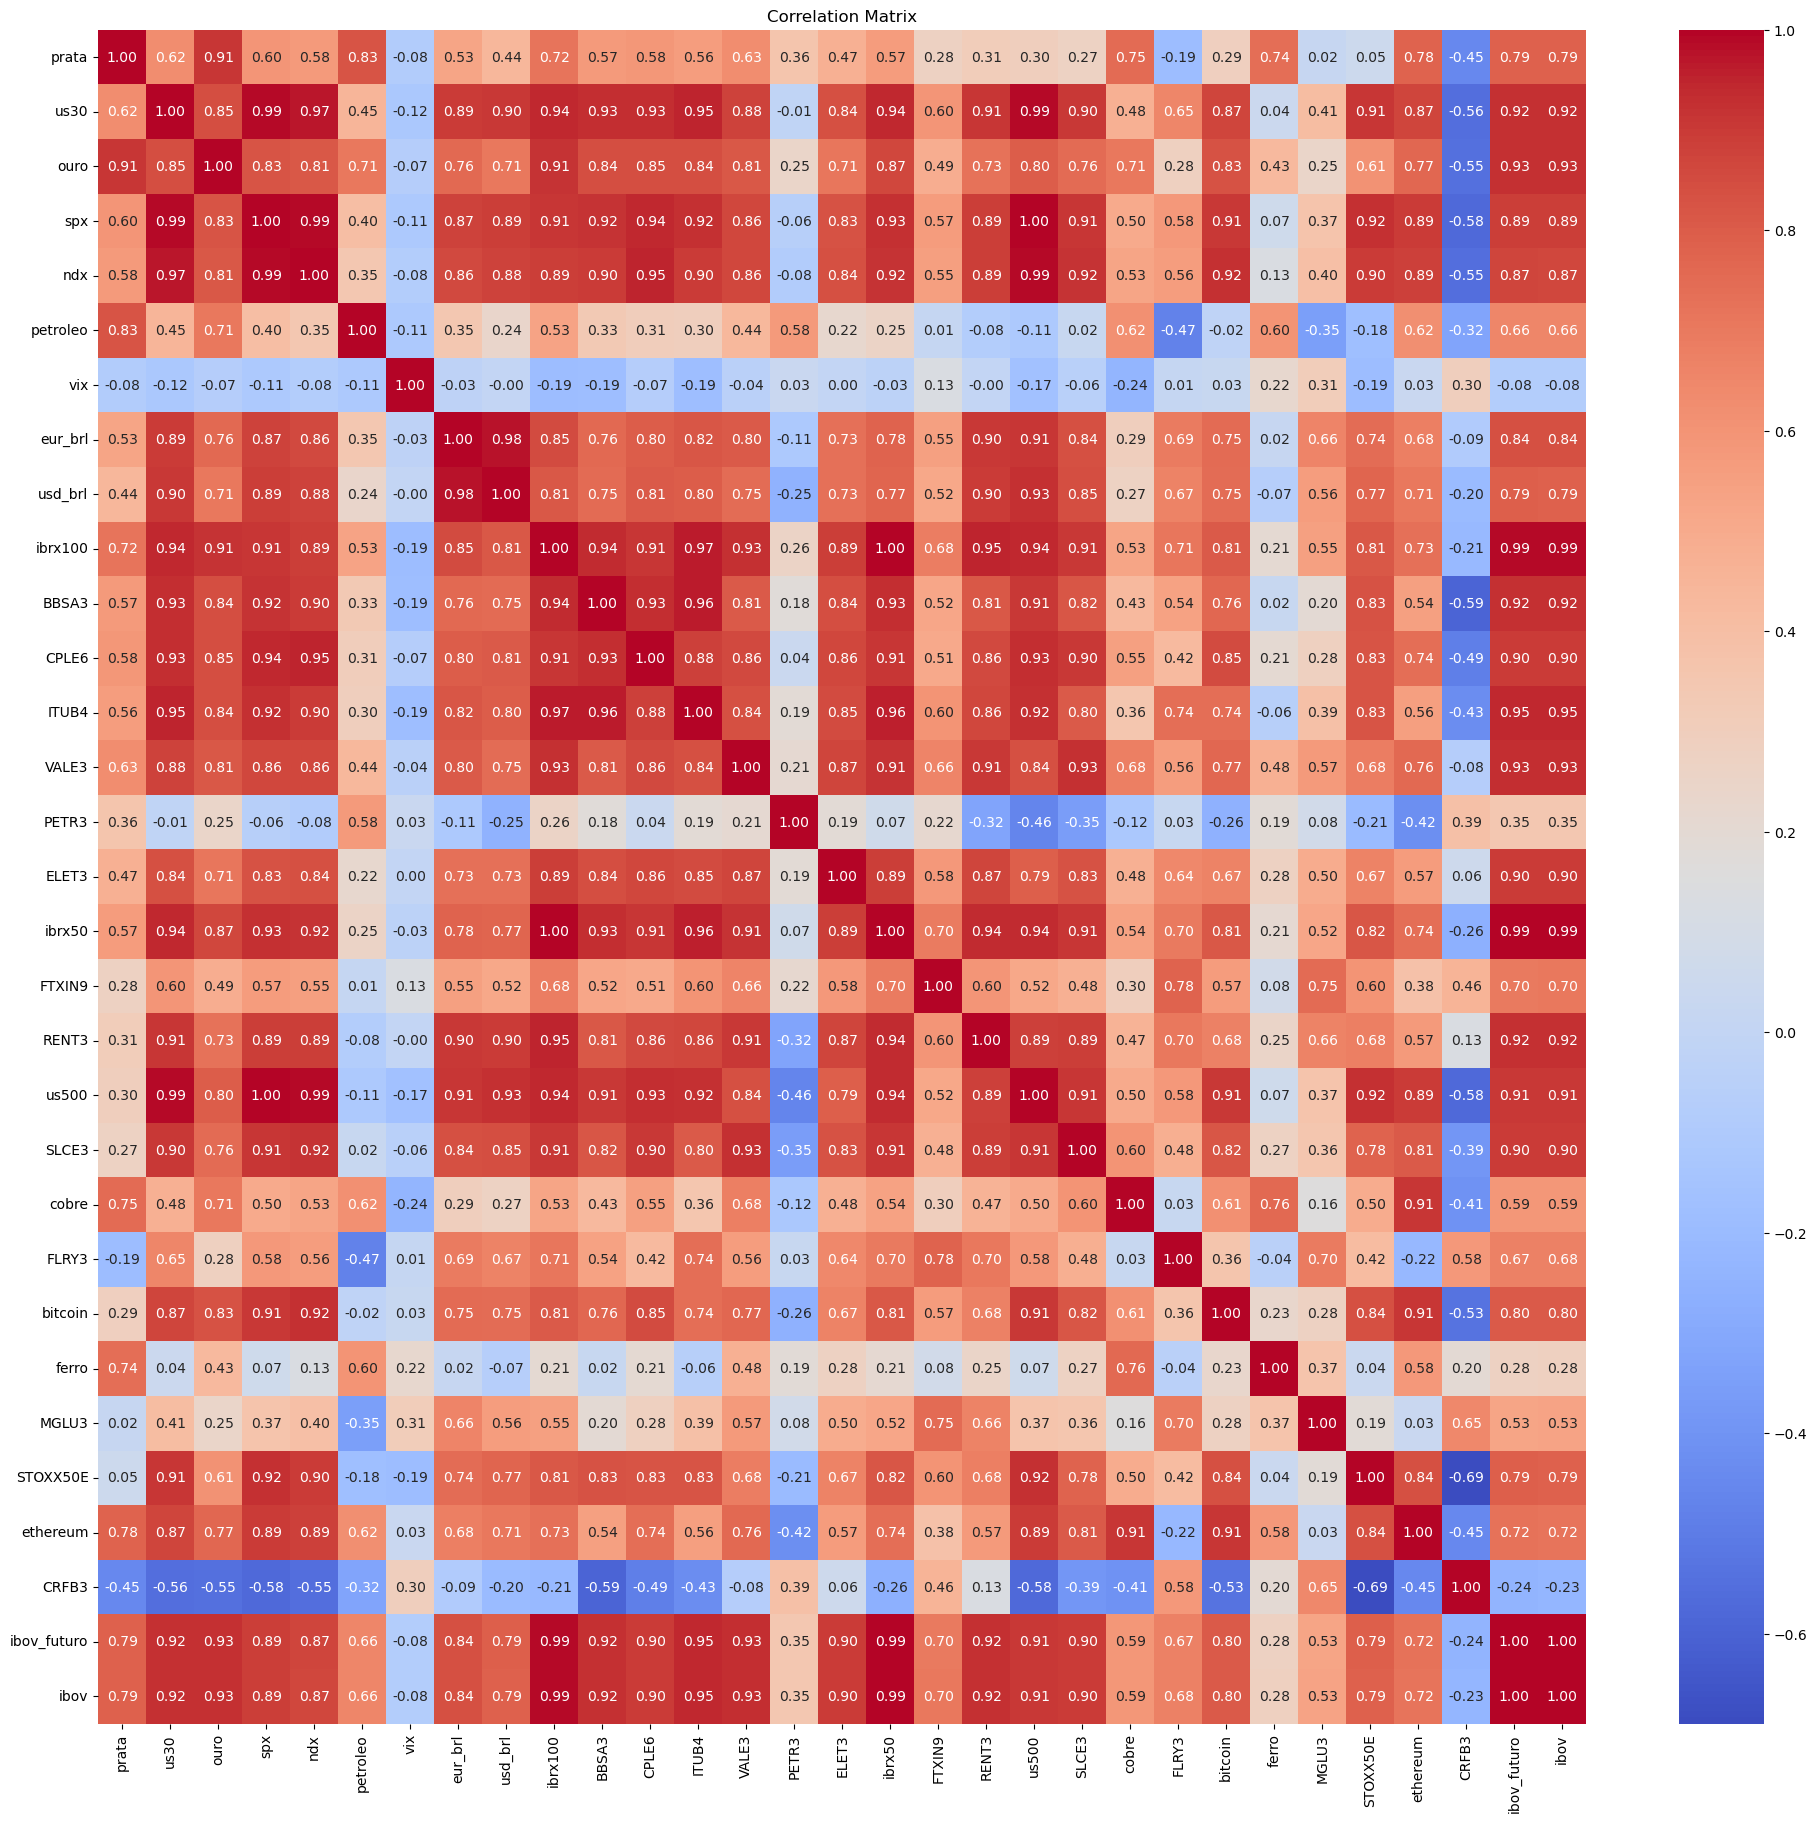

In [57]:
plt.figure(figsize=(24, 22))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

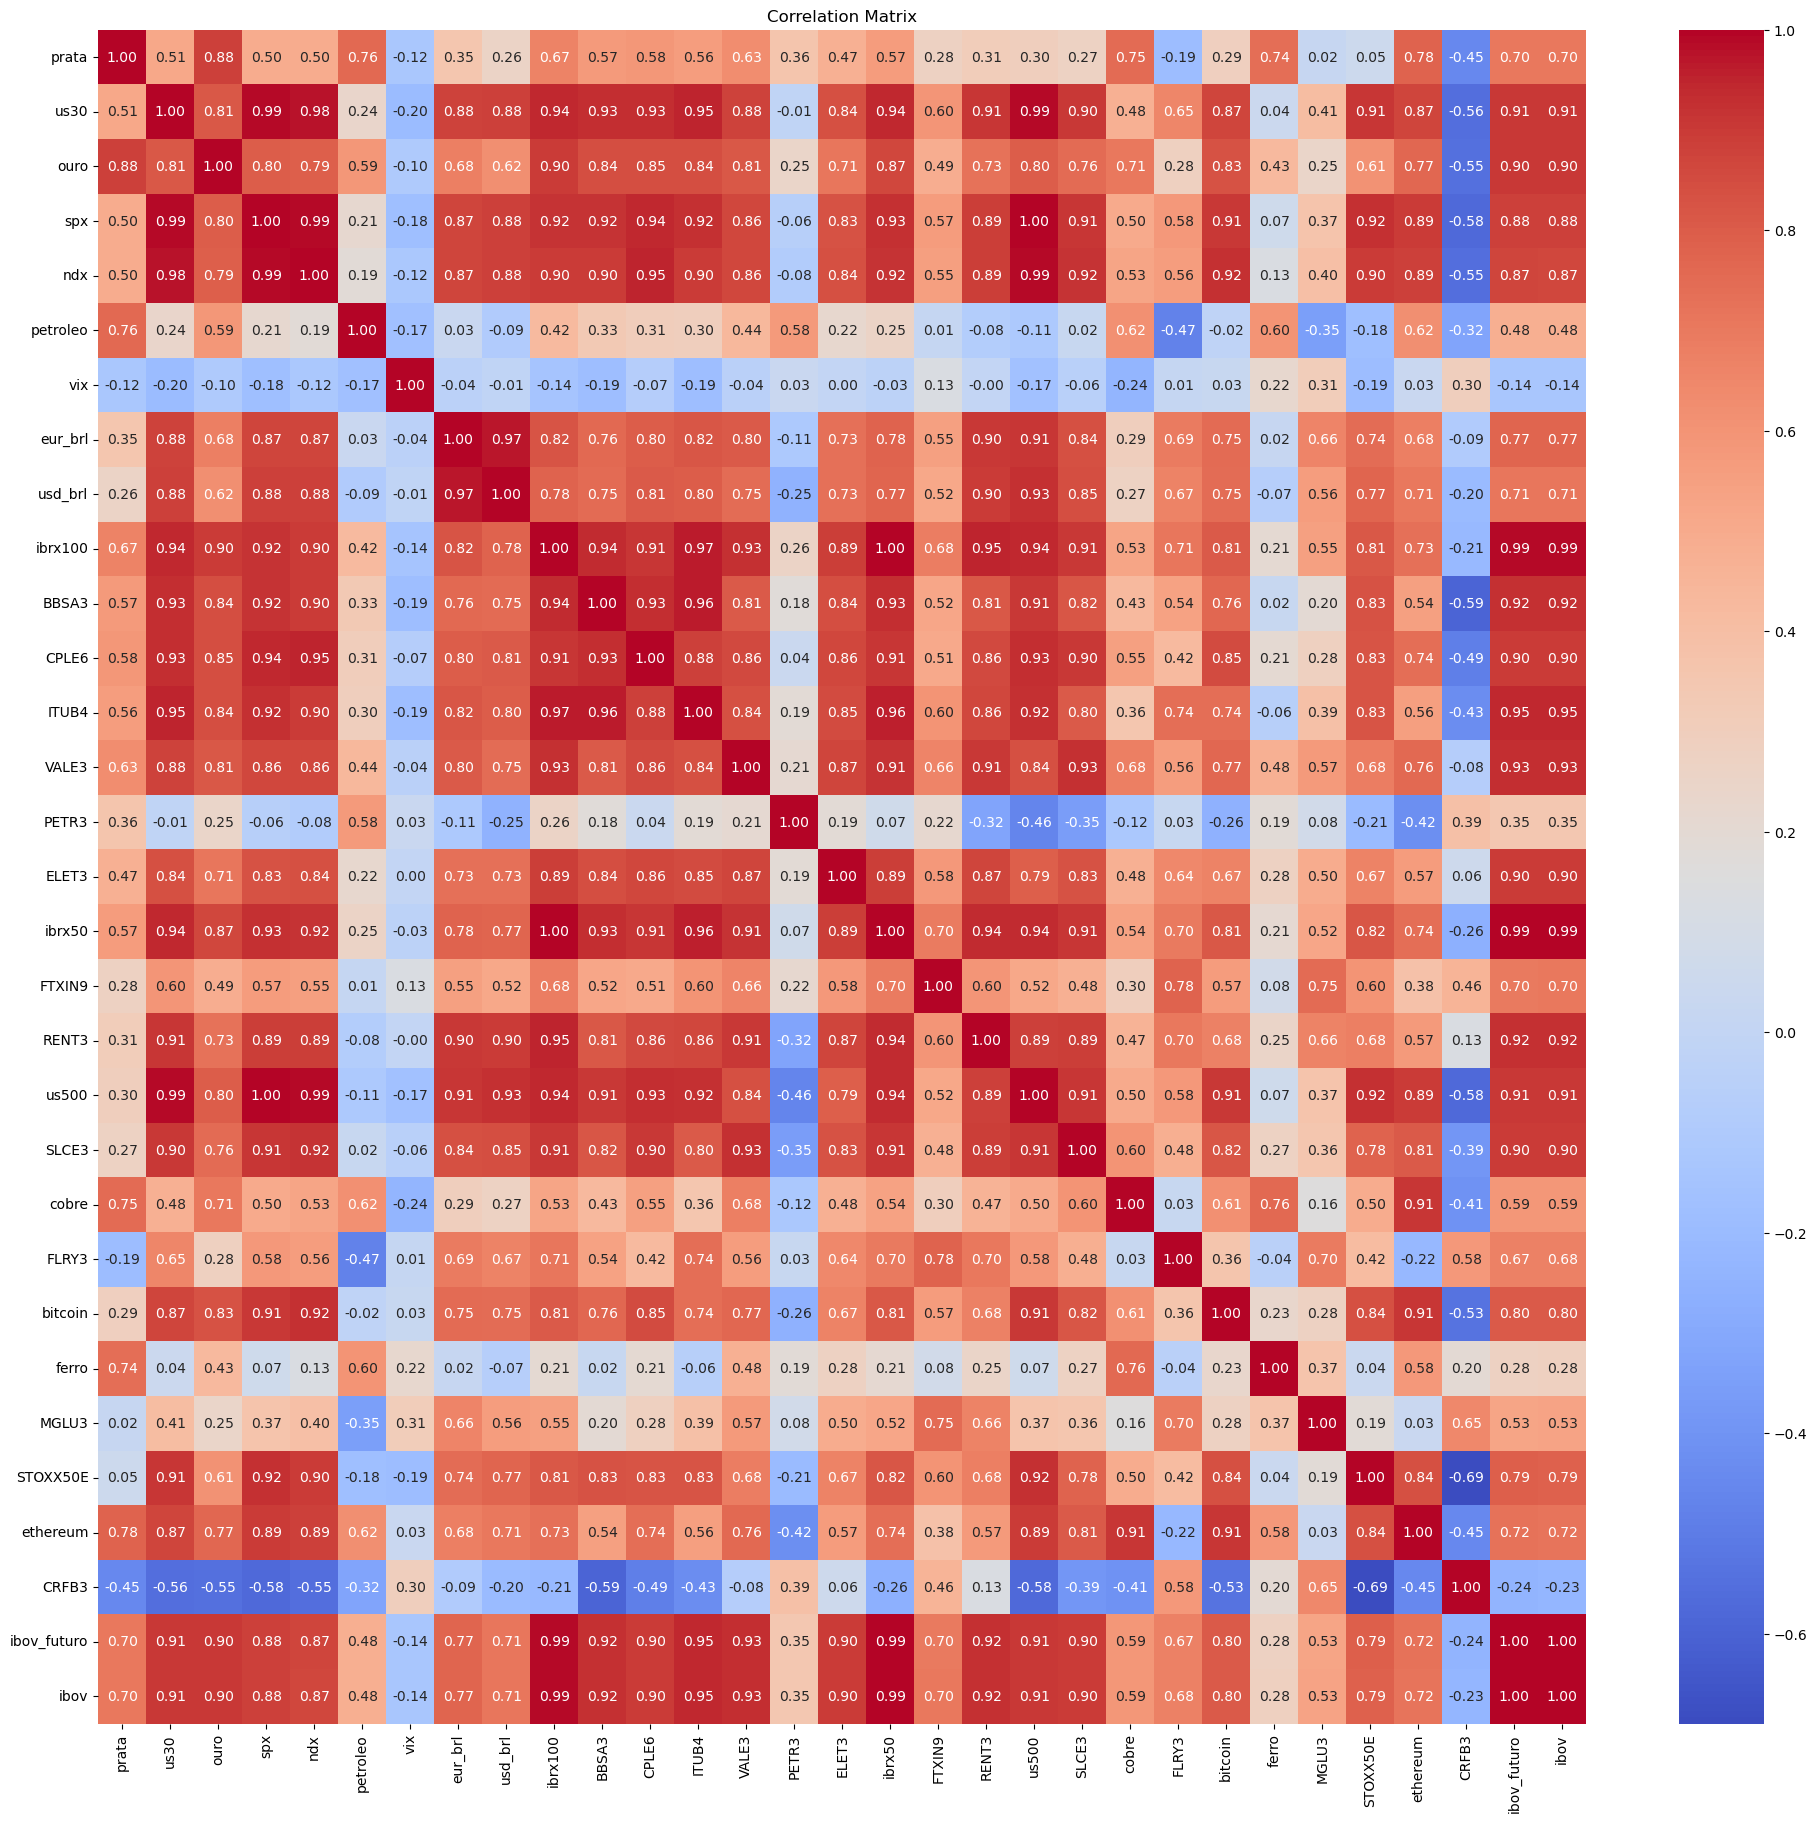

In [58]:
plt.figure(figsize=(24, 22))
sns.heatmap(correlation_matrix_2k, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Timeseries Forecast Model

## Análise exploratória do dados

### Preparação dos dados

In [59]:
df = df[['data', 'ibov']]

df.index = pd.to_datetime(df.data, format = '%m-%d-%Y')

df.drop('data', inplace=True, axis=1)

### Ajuste temporal dos dados

In [60]:
df = df[df.index >= '1994-01-01']

### Visualização dos dados históricos do Índice Ibovespa

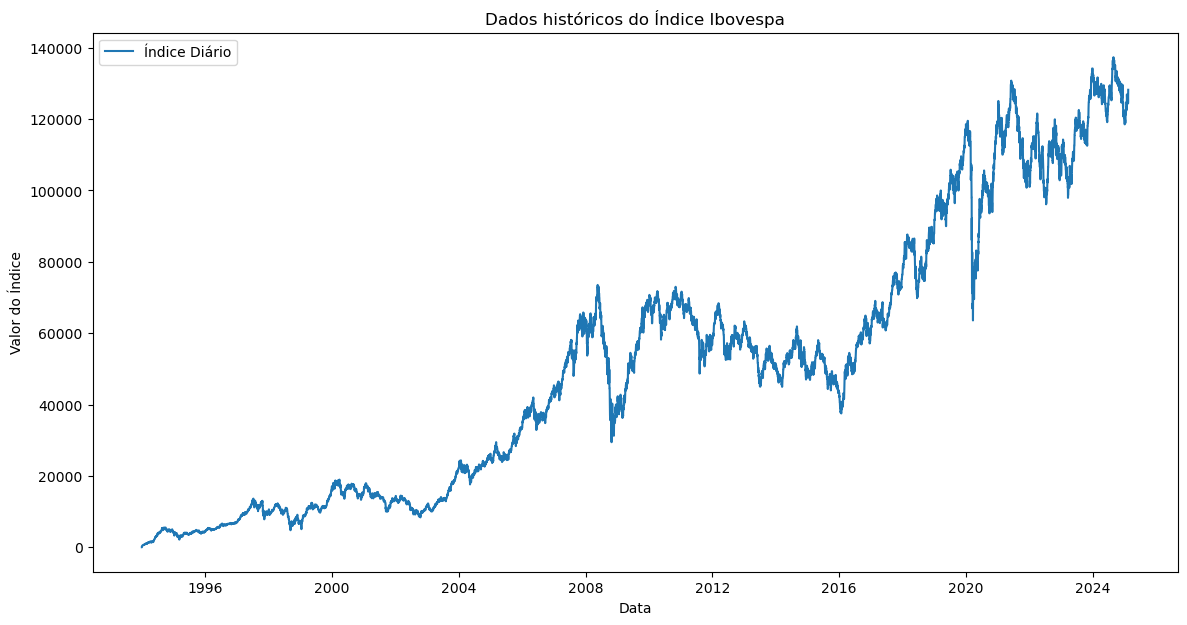

In [61]:
# Plot dos dados originais
plt.figure(figsize=(14, 7))
plt.plot(df.index, df["ibov"], label="Índice Diário")
plt.title("Dados históricos do Índice Ibovespa")
plt.xlabel("Data")
plt.ylabel("Valor do Índice")
plt.legend()
plt.show()

### Decomposição da série temporal

<Axes: xlabel='data'>

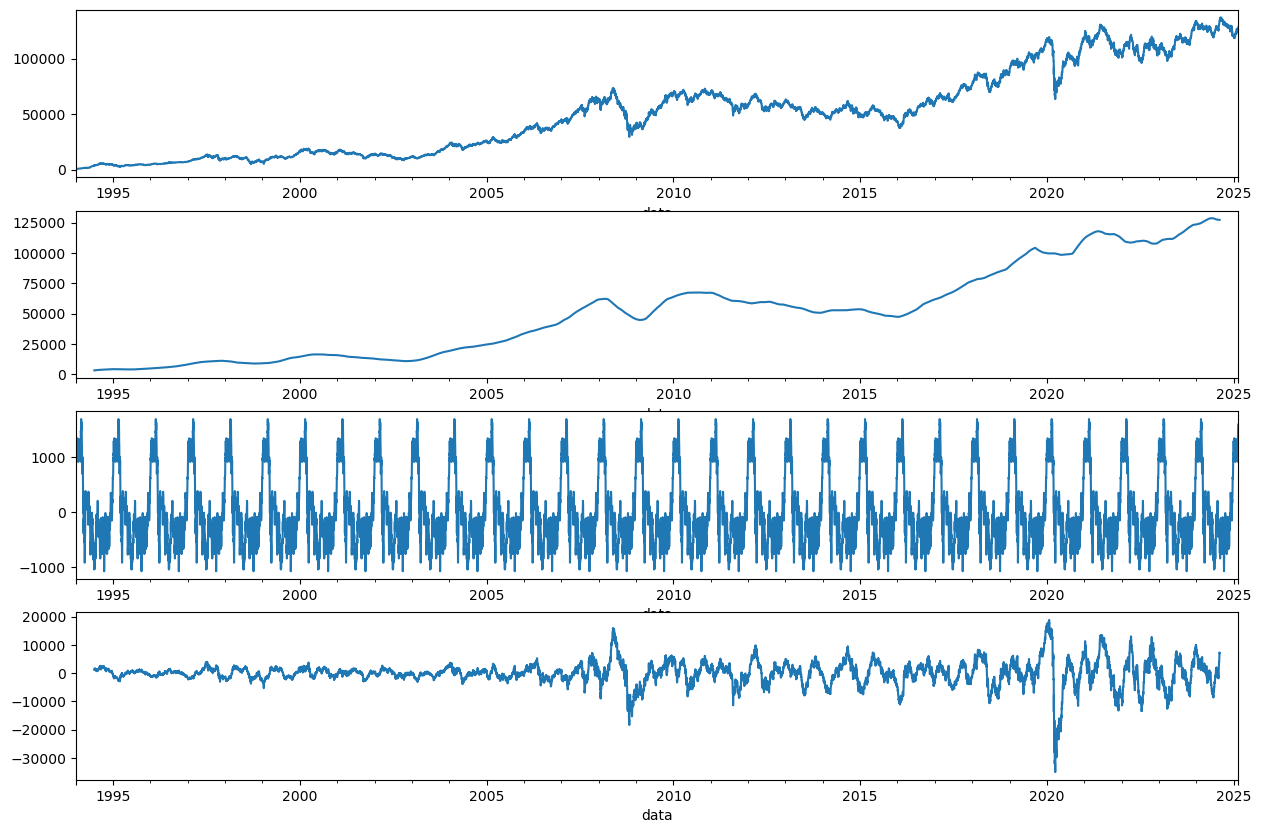

In [62]:
resultados = seasonal_decompose(df, period=365)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(15, 10))

resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

## Teste de Estacionalidade

### Teste de Dickey-Fuller Aumentado (ADF)

In [63]:
# Teste ADF
resultado_adf = adfuller(df["ibov"].dropna())
print(f"Estatística ADF: {resultado_adf[0]}")
print(f"Valor-p: {100*resultado_adf[1]:.2f}%")

# Interpretação
if resultado_adf[1] < 0.05:
    print("A série é estacionária.")
else:
    print("A série não é estacionária.")

Estatística ADF: -0.5468329897268545
Valor-p: 88.25%
A série não é estacionária.


### Diferenciação de primeira ordem

In [64]:
'''
# Diferenciação de primeira ordem
df["ibov_diff"] = df["ibov"] - df["ibov"].shift(1)
df["ibov_diff"] = df["ibov_diff"].dropna()

# Plot da série diferenciada
plt.figure(figsize=(14, 7))
plt.plot(df.index, df["ibov_diff"], label="Série Diferenciada (1ª Ordem)")
plt.title("Série Diferenciada (1ª Ordem)")
plt.xlabel("Data")
plt.ylabel("Valor do Índice")
plt.legend()
plt.show()
'''

'\n# Diferenciação de primeira ordem\ndf["ibov_diff"] = df["ibov"] - df["ibov"].shift(1)\ndf["ibov_diff"] = df["ibov_diff"].dropna()\n\n# Plot da série diferenciada\nplt.figure(figsize=(14, 7))\nplt.plot(df.index, df["ibov_diff"], label="Série Diferenciada (1ª Ordem)")\nplt.title("Série Diferenciada (1ª Ordem)")\nplt.xlabel("Data")\nplt.ylabel("Valor do Índice")\nplt.legend()\nplt.show()\n'

### Teste ADF na série transformada

In [65]:
'''
# Teste ADF na série diferenciada
resultado_adf_diff = adfuller(df["ibov_diff"].dropna())
print(f"Estatística ADF: {resultado_adf_diff[0]}")
print(f"Valor-p: {100*resultado_adf_diff[1]:.4}%")

# Interpretação
if resultado_adf_diff[1] < 0.05:
    print("A série diferenciada é estacionária.")
else:
    print("A série diferenciada não é estacionária.")'
'''

'\n# Teste ADF na série diferenciada\nresultado_adf_diff = adfuller(df["ibov_diff"].dropna())\nprint(f"Estatística ADF: {resultado_adf_diff[0]}")\nprint(f"Valor-p: {100*resultado_adf_diff[1]:.4}%")\n\n# Interpretação\nif resultado_adf_diff[1] < 0.05:\n    print("A série diferenciada é estacionária.")\nelse:\n    print("A série diferenciada não é estacionária.")\'\n'

## Identificação dos parâmetros do modelo

### Identifica ACF e PACF

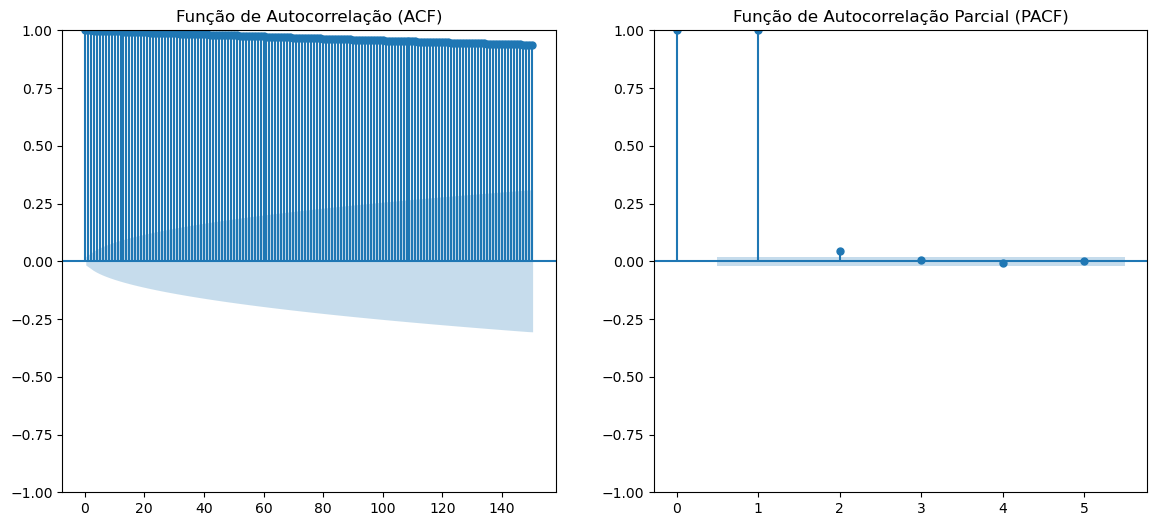

In [66]:
# Plot da ACF e PACF da série diferenciada
plt.figure(figsize=(14, 6))
plt.subplot(121)
plot_acf(df["ibov"].dropna(), ax=plt.gca(), lags=150)
plt.title("Função de Autocorrelação (ACF)")
plt.subplot(122)
plot_pacf(df["ibov"].dropna(), ax=plt.gca(), lags=5)
plt.title("Função de Autocorrelação Parcial (PACF)")
plt.show()

In [67]:
# TODO: Avaliar os resultados desses parâmetros, talvez reduzirmos os dados da série história
p = 2  # Quando gráfico PACF cruz o cone pela primeira vez
q = 80 # Quando gráfico ACF cruz o cone pela primeira vez
d = 0  # quantas vezes a série foi diferenciada até se tornar estacionária

## Splitando os dados de Teste e Treino

In [75]:
# Definição dos dados de teste e treino
train_end = '2025-01-01'
df_training = df.loc[:train_end]
df_test = df.loc[train_end:]

## Função para calcular o WMAPE

In [70]:
# Função para calcular WMAPE
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / (np.sum(y_true) + 1e-10)

## Naive

### Ajuste e previsão do modelo

c:\Users\LucasRamos\anaconda3\envs\posdatascience\lib\site-packages\statsforecast\core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


WMAPE: 2.58%


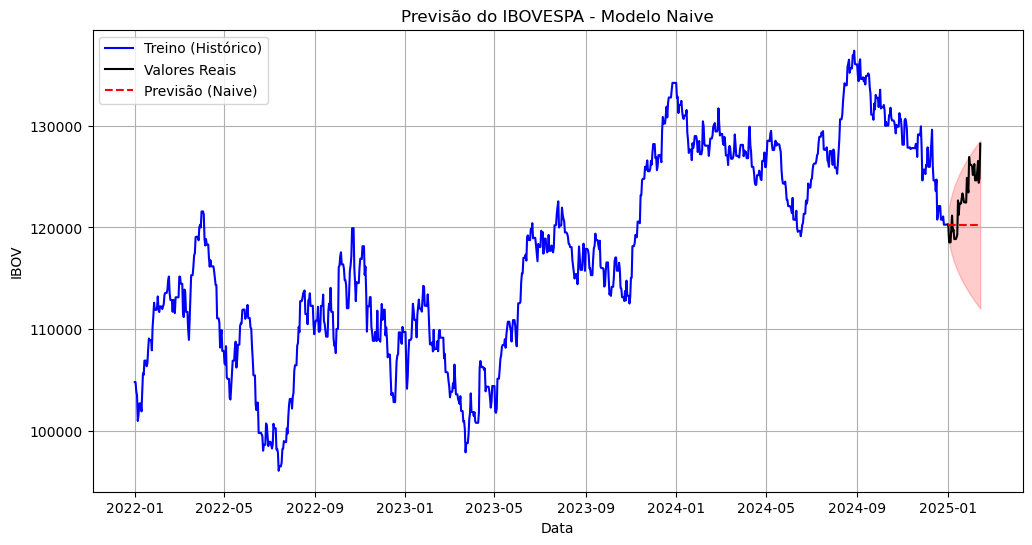

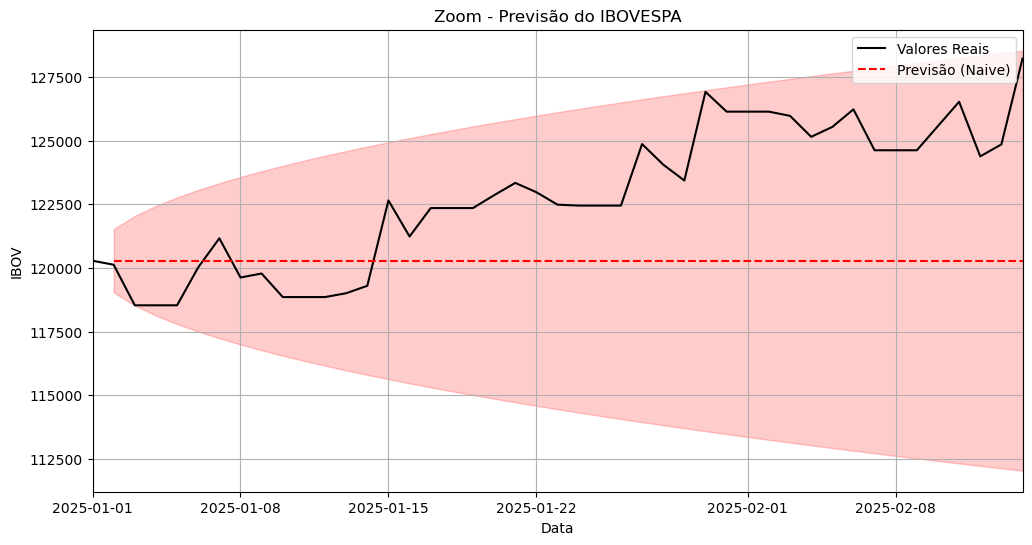

In [ ]:
# Estruturação para modelagem
treino_naive = df_training.rename(columns={'ibov': 'y'})
treino_naive['ds'] = treino_naive.index
treino_naive.reset_index(drop=True)
treino_naive['unique_id'] = 'IBOV'
valid_naive = df_test.rename(columns={'ibov': 'y'})
valid_naive['ds'] = valid_naive.index
valid_naive.reset_index(drop=True)

# Definição do horizonte de previsão
h = valid_naive.shape[0]

# Configuração e treinamento do modelo
model_naive = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
model_naive.fit(treino_naive[['unique_id', 'ds', 'y']])

# Fazer previsão para o mesmo período da validação
forecast_df_naive = model_naive.predict(h=h, level=[90])
forecast_df_naive['ds'] = pd.to_datetime(forecast_df_naive.ds, format = '%m-%d-%Y')

# Merge com valores reais
forecast_df_naive = forecast_df_naive.merge(valid_naive, on='ds', how='left')
forecast_df_naive.dropna(subset=['y', 'Naive'], inplace=True)

forecast_df_naive['diff_perc'] = abs(forecast_df_naive['y'] - forecast_df_naive['Naive'])/forecast_df_naive['y']
forecast_df_naive['precision'] = 1 - forecast_df_naive['diff_perc']

# Cálculo do erro WMAPE
if not forecast_df_naive.empty and forecast_df_naive['y'].sum() > 0:
    erro_wmape = wmape(forecast_df_naive['y'].values, forecast_df_naive['Naive'].values)
    print(f'WMAPE: {erro_wmape:.2%}')
else:
    print("Erro: Não há valores suficientes para calcular WMAPE.")

# Função para plotar os resultados
def plot_forecast_naive(treino, valid, forecast_df, title="Previsão do IBOVESPA - Modelo Naive"):
    treino_filtered = treino[treino['ds'] >= '2022-01-01']
    valid_filtered = valid[valid['ds'] >= '2022-01-01']
    forecast_filtered = forecast_df[forecast_df['ds'] >= '2022-01-01']

    plt.figure(figsize=(12, 6))
    plt.plot(treino_filtered['ds'], treino_filtered['y'], label="Treino (Histórico)", color="blue")
    plt.plot(valid_filtered['ds'], valid_filtered['y'], label="Valores Reais", color="black")
    plt.plot(forecast_filtered['ds'], forecast_filtered['Naive'], label="Previsão (Naive)", color="red", linestyle="dashed")

    plt.fill_between(forecast_filtered['ds'], 
                     forecast_filtered['Naive-lo-90'], 
                     forecast_filtered['Naive-hi-90'], 
                     color='red', alpha=0.2)

    plt.xlabel("Data")
    plt.ylabel("IBOV")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

    # Adicionar zoom na parte final
    plt.figure(figsize=(12, 6))
    zoom_start = valid['ds'].min()
    plt.plot(valid['ds'], valid['y'], label="Valores Reais", color="black")
    plt.plot(forecast_df['ds'], forecast_df['Naive'], label="Previsão (Naive)", color="red", linestyle="dashed")
    plt.fill_between(forecast_df['ds'], forecast_df['Naive-lo-90'], forecast_df['Naive-hi-90'], color='red', alpha=0.2)
    plt.xlabel("Data")
    plt.ylabel("IBOV")
    plt.title("Zoom - Previsão do IBOVESPA")
    plt.legend()
    plt.grid()
    plt.xlim(zoom_start, forecast_df['ds'].max())
    plt.show()

# Plot dos resultados
plot_forecast_naive(treino_naive, valid_naive, forecast_df_naive)

## Seasonal Naive

### Funções Auxiliares

In [ ]:
def seazonal_naive(df_training, df_test, period):
  
  # Estruturação para modelagem
  treino = df_training.rename(columns={'ibov': 'y'})
  treino['ds'] = treino.index
  treino.reset_index(drop=True)
  treino['unique_id'] = 'IBOV'
  valid = df_test.rename(columns={'ibov': 'y'})
  valid['ds'] = valid.index
  valid.reset_index(drop=True)

  h = valid.shape[0]

  # Configuração e treinamento do modelo
  model_s = StatsForecast(models=[SeasonalNaive(season_length=period)], freq='D', n_jobs=-1) # Considerando sazonalidade de mensal, caso a gente queira mudar (semanal (7) / trimestral (90) / semestral (180) / anual (365), alterar aqui)
  model_s.fit(treino[['unique_id', 'ds', 'y']])

  # Fazer previsão para o mesmo período da validação
  forecast_df = model_s.predict(h=h, level=[90])
  forecast_df['ds'] = pd.to_datetime(forecast_df.ds, format = '%m-%d-%Y')

  # Merge com valores reais
  forecast_df = forecast_df.merge(valid, on='ds', how='left')
  forecast_df.dropna(subset=['y', 'SeasonalNaive'], inplace=True)

  forecast_df['diff_perc'] = abs(forecast_df['y'] - forecast_df['SeasonalNaive'])/forecast_df['y']
  forecast_df['precision'] = 1 - forecast_df['diff_perc']

  # Cálculo do erro WMAPE
  if not forecast_df.empty and forecast_df['y'].sum() > 0:
      erro_wmape = wmape(forecast_df['y'].values, forecast_df['SeasonalNaive'].values)
      print(f'WMAPE: {erro_wmape:.2%}')
  else:
      print("Erro: Não há valores suficientes para calcular WMAPE.")

  return treino, valid, forecast_df

# Função para plotar os resultados
def plot_forecast(treino, valid, forecast_df, title="Previsão do IBOVESPA"):
    
    treino_filtered = treino[treino['ds'] >= '2024-01-01']
    valid_filtered = valid[valid['ds'] >= '2024-01-01']
    forecast_filtered = forecast_df[forecast_df['ds'] >= '2024-01-01']
    
    plt.figure(figsize=(12, 6))
    plt.plot(treino_filtered['ds'], treino_filtered['y'], label="Treino (Histórico)", color="blue")
    plt.plot(valid_filtered['ds'], valid_filtered['y'], label="Valores Reais", color="black")
    plt.plot(forecast_filtered['ds'], forecast_filtered['SeasonalNaive'], label="Previsão (SeasonalNaive)", color="red", linestyle="dashed")
    
    plt.fill_between(forecast_filtered['ds'], 
                     forecast_filtered['SeasonalNaive-lo-90'], 
                     forecast_filtered['SeasonalNaive-hi-90'], 
                     color='red', alpha=0.2)
    
    plt.xlabel("Data")
    plt.ylabel("IBOV")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

    # Adicionar zoom na parte final
    plt.figure(figsize=(12, 6))
    zoom_start = valid['ds'].min()  # Pega o início da validação para focar no zoom
    plt.plot(valid['ds'], valid['y'], label="Valores Reais", color="black")
    plt.plot(forecast_df['ds'], forecast_df['SeasonalNaive'], label="Previsão (SeasonalNaive)", color="red", linestyle="dashed")
    plt.fill_between(forecast_df['ds'], forecast_df['SeasonalNaive-lo-90'], forecast_df['SeasonalNaive-hi-90'], color='red', alpha=0.2)
    plt.xlabel("Data")
    plt.ylabel("IBOV")
    plt.title("Zoom - Previsão do IBOVESPA")
    plt.legend()
    plt.grid()
    plt.xlim(zoom_start, forecast_df['ds'].max())  # Define um range menor para foco na previsão
    plt.show()

### Ajuste e previsão do modelo semanal

c:\Users\LucasRamos\anaconda3\envs\posdatascience\lib\site-packages\statsforecast\core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


WMAPE: 2.54%


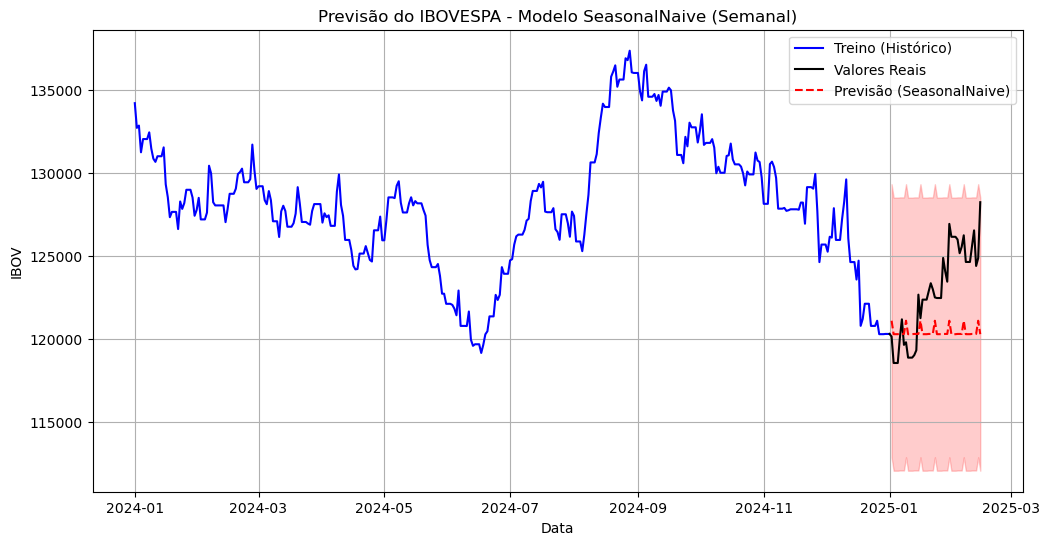

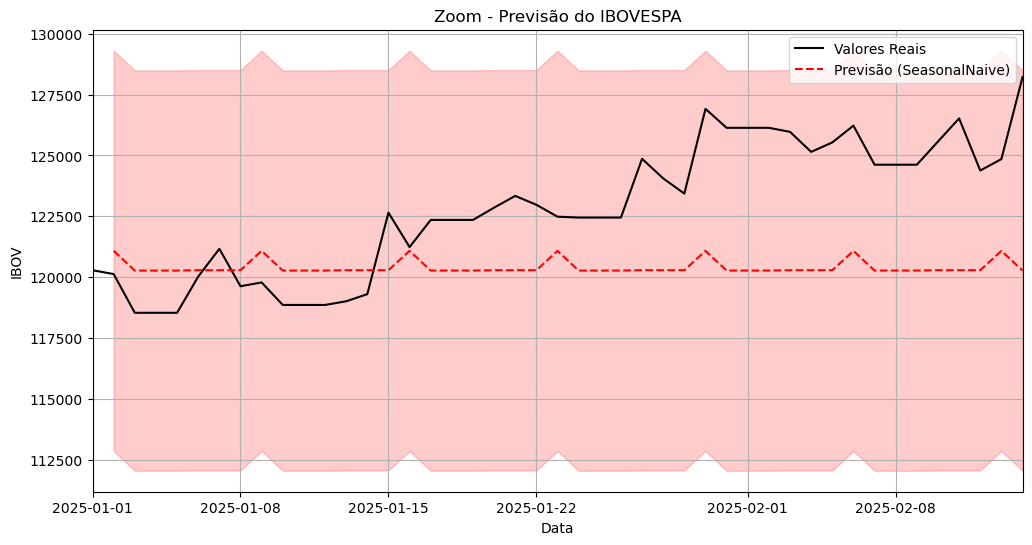

In [159]:
treino_seazonal_naive, valid_seazonal_naive, forecast_df_seazonal_naive = seazonal_naive(df_training, df_test, PERIOD_SEAZONAL_NAIVE_WEEKLY)

# Plot dos resultados
plot_forecast(treino_seazonal_naive, valid_seazonal_naive, forecast_df_seazonal_naive, "Previsão do IBOVESPA - Modelo SeasonalNaive (Semanal)")
    

### Ajuste e previsão do modelo mensal

c:\Users\LucasRamos\anaconda3\envs\posdatascience\lib\site-packages\statsforecast\core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


WMAPE: 2.89%


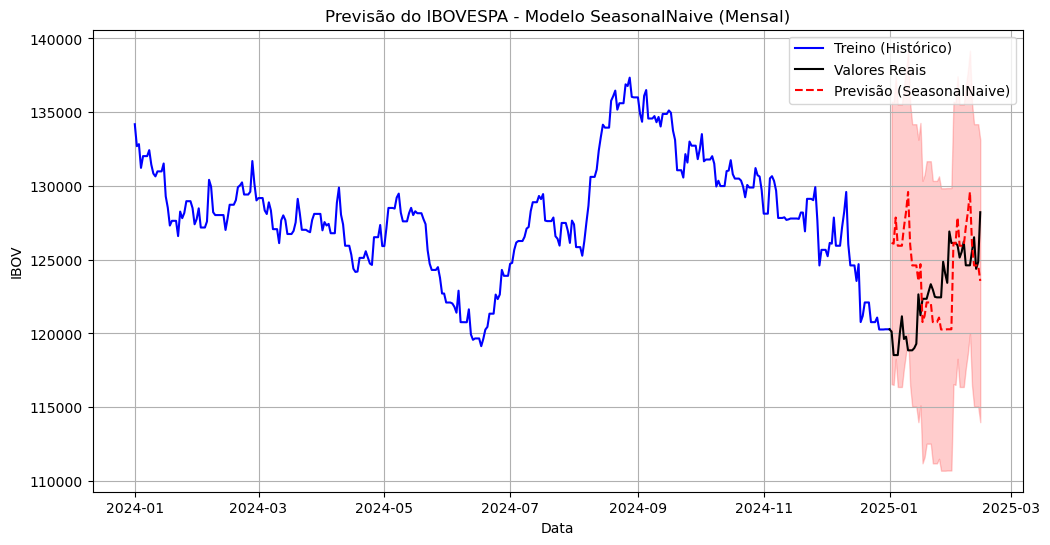

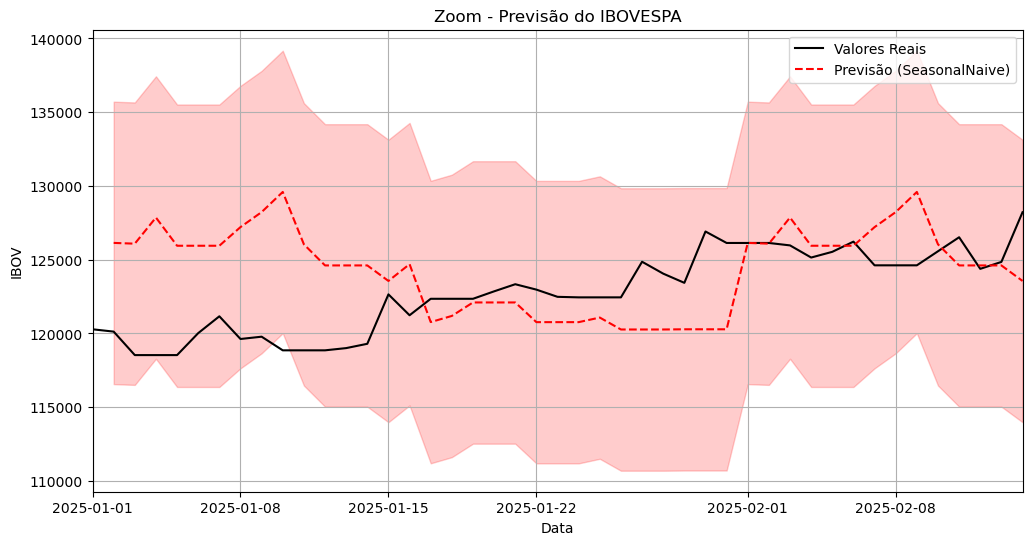

In [158]:
treino_seazonal_naive_month, valid_seazonal_naive_month, forecast_df_seazonal_naive_month = seazonal_naive(df_training, df_test, PERIOD_SEAZONAL_NAIVE_MONTHLY)

# Plot dos resultados
plot_forecast(treino_seazonal_naive_month, valid_seazonal_naive_month, forecast_df_seazonal_naive_month, "Previsão do IBOVESPA - Modelo SeasonalNaive (Mensal)")

### ARIMA

### Ajuste do modelo

In [ ]:
# Select the column to forecast, for example 'ultimo'
ts = df_training['ibov']

#TODO: 'Avaliar os parâmetros conforme identificado nos testes ACF e PACF'
# Fit ARIMA model
model_naive = ARIMA(ts, order=(5, 1, 0))
model_fit = model_naive.fit()

# Forecast
forecast_steps = 45
forecast = model_fit.forecast(steps=forecast_steps)

# Create a new datetime index for the forecast steps
forecast_dates = pd.date_range(start=ts.index[-1], periods=forecast_steps)

# Combine the forecast dates with the forecast values
forecast_series = pd.Series(forecast.values, index=forecast_dates)

c:\Users\LucasRamos\anaconda3\envs\posdatascience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LucasRamos\anaconda3\envs\posdatascience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LucasRamos\anaconda3\envs\posdatascience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


### Previsão do Modelo

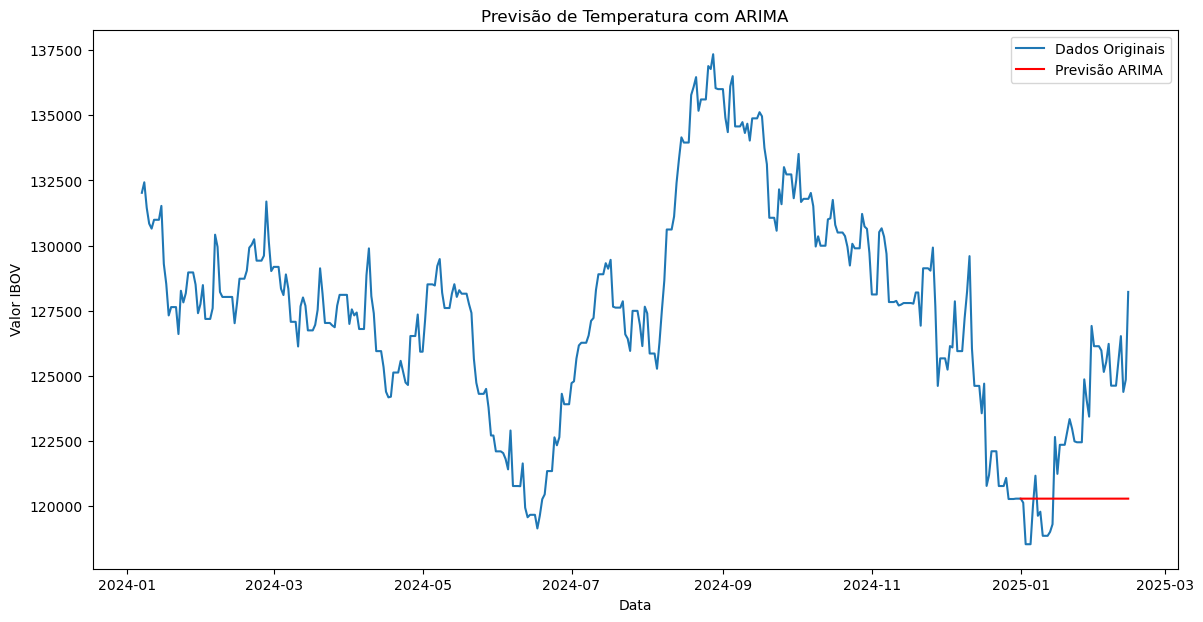

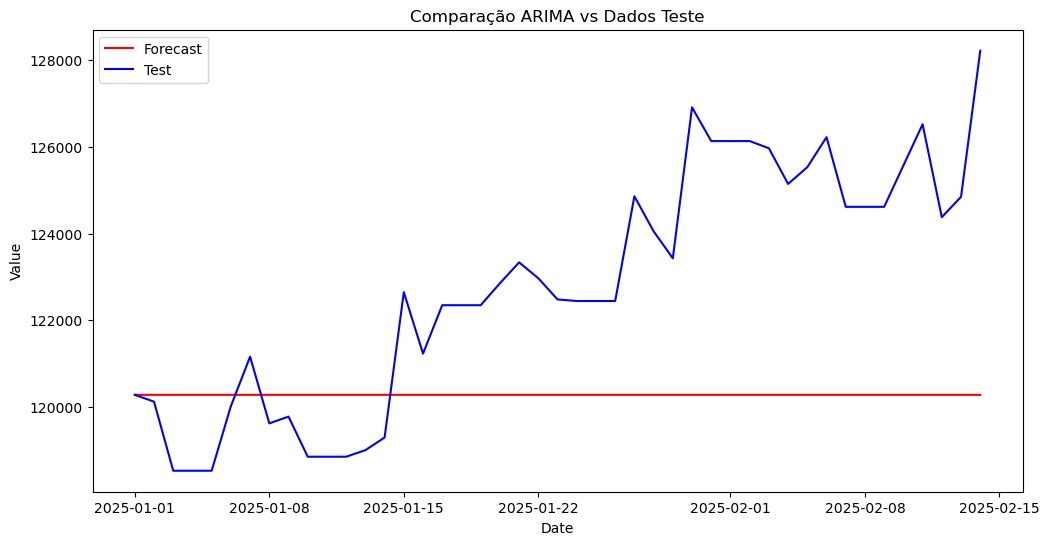

In [114]:
# Plot das previsões
plt.figure(figsize=(14, 7))
plt.plot(df["ibov"].iloc[-405:], label="Dados Originais")
plt.plot(forecast_series.index, forecast_series, color="red", label="Previsão ARIMA")
plt.title("Previsão de Temperatura com ARIMA")
plt.xlabel("Data")
plt.ylabel("Valor IBOV")
plt.legend()
plt.show()

# Plot the comparison between forecast_series and df_test
plt.figure(figsize=(12, 6))
plt.plot(forecast_series, label='Forecast', color='red')
plt.plot(df_test.index, df_test['ibov'], label='Test', color='blue')
plt.title('Comparação ARIMA vs Dados Teste')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [108]:
df_forecast = pd.DataFrame({'forecast': forecast_series}).reset_index().rename(columns={'index': 'data'})

df_forecast['data'] = df_forecast['data'].apply(lambda x: x.date())

df_forecast.index = pd.to_datetime(df_forecast.data, format = '%m-%d-%Y')
df_forecast.drop('data', inplace=True, axis=1)

df_forecast = df_forecast.merge(df_test, left_index=True, right_index=True, how='right')
df_forecast['diff'] = df_forecast['ibov'] - df_forecast['forecast']
df_forecast['diff_perc'] = abs(df_forecast['ibov'] - df_forecast['forecast'])/df_forecast['ibov']
df_forecast['precision'] = 1 - df_forecast['diff_perc']

### Testes de precisão do modelo ARIMA

In [ ]:
df_forecast['precision'].mean()

0.9751046429068028

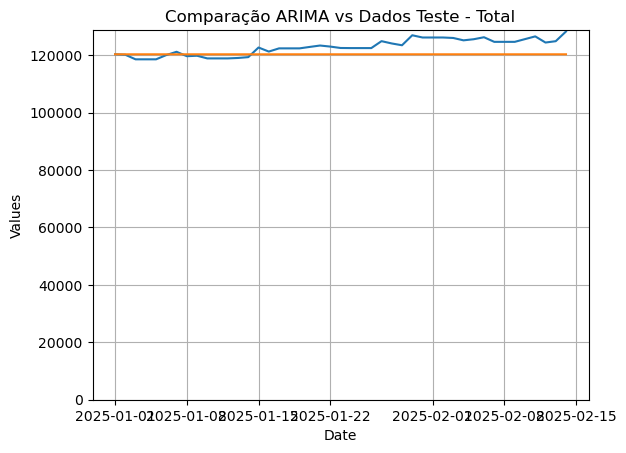

<Figure size 1200x600 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()

plt.figure(figsize=(12, 6))

ax.plot(df_forecast.index, df_forecast['ibov'], label='Value')
ax.plot(df_forecast.index, df_forecast['forecast'], label='Forecast')

ax.grid()
ax.set(
    xlabel='Date',
    ylabel='Values',
    title='Comparação ARIMA vs Dados Teste - Total'
)

ax.set_ylim(ymin=0)

plt.show()

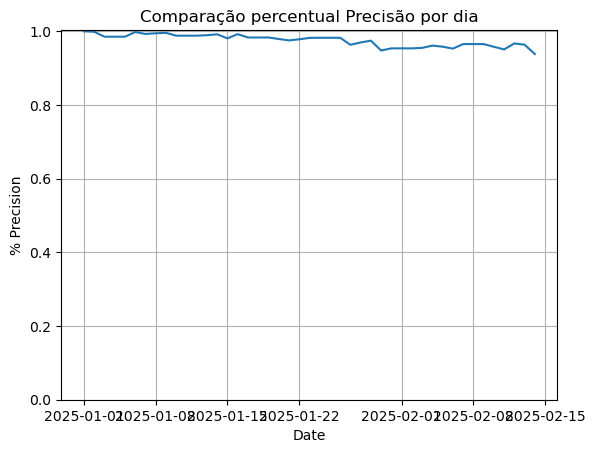

<Figure size 1200x600 with 0 Axes>

In [ ]:
df_precision = df_forecast[['precision']]
#df_precision = df_forecast[['data', 'precision']]

fig, ax = plt.subplots()

plt.figure(figsize=(12, 6))

ax.plot(df_precision.index, df_precision['precision'], label='a')
ax.set_ylim(ymin=0)
ax.grid()
ax.set(
    xlabel='Date',
    ylabel='% Precision',
    title='Comparação percentual Precisão por dia'
)

plt.show()

## SARIMA

### Ajuste do Modelo

In [115]:
s = 12  # assumindo sazonaliade semanal
#model_sarimax = SARIMAX(df_training['ibov'], order=(p, d, q), seasonal_order=(1, 1, 0, s))
model_sarimax = SARIMAX(df_training['ibov'], order=(5, 1, 0), seasonal_order=(1, 1, 0, s))
resultado_sarimax = model_sarimax.fit()

# Predict on test set
sarimax_pred = resultado_sarimax.forecast(len(df_test))
mse_sarimax = mean_squared_error(df_test['ibov'], sarimax_pred)
print(f'SARIMA MSE: {mse_sarimax}')

c:\Users\LucasRamos\anaconda3\envs\posdatascience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LucasRamos\anaconda3\envs\posdatascience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


SARIMA MSE: 83228763.36564684


### Previsão do modelo

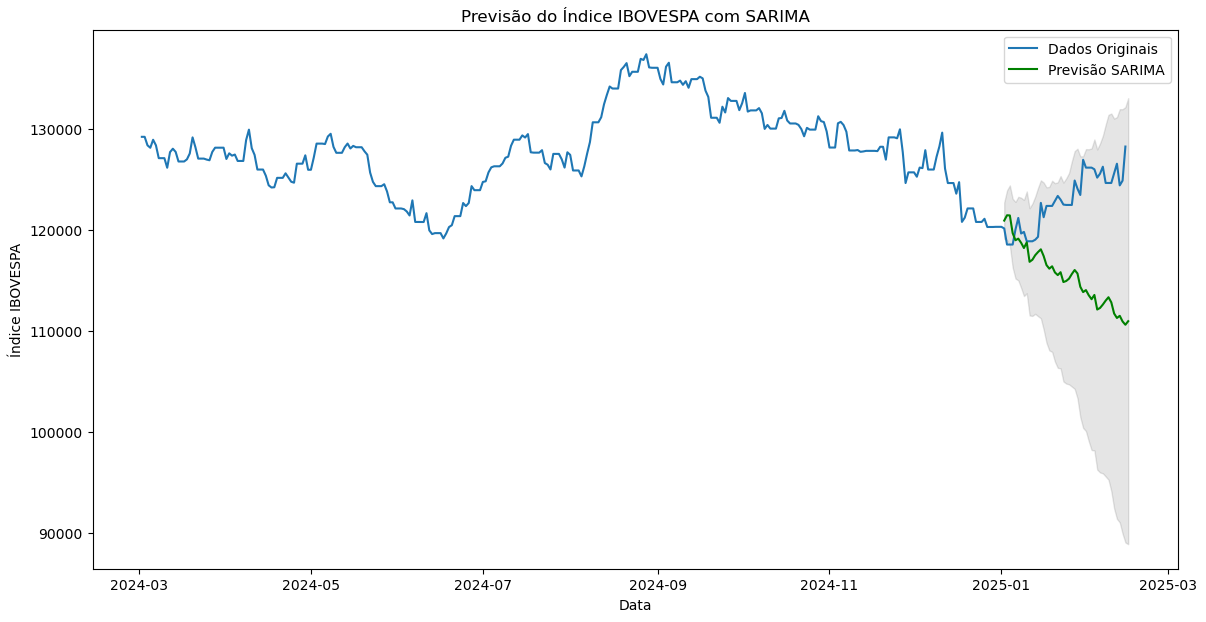

In [116]:
# Previsão dos próximos 45 dias
forecast_sarima = resultado_sarimax.get_forecast(steps=45)
forecast_sarima_mean = forecast_sarima.predicted_mean
forecast_sarima_conf_int = forecast_sarima.conf_int()

# Plot das previsões
plt.figure(figsize=(14, 7))
plt.plot(df["ibov"].iloc[-350:], label="Dados Originais")
plt.plot(
    forecast_sarima_mean.index,
    forecast_sarima_mean,
    color="green",
    label="Previsão SARIMA",
)
plt.fill_between(
    forecast_sarima_conf_int.index,
    forecast_sarima_conf_int.iloc[:, 0],
    forecast_sarima_conf_int.iloc[:, 1],
    color="k",
    alpha=0.1,
)
plt.title("Previsão do Índice IBOVESPA com SARIMA")
plt.xlabel("Data")
plt.ylabel("Índice IBOVESPA")
plt.legend()
plt.show()

## Comparação de resultado entre modelos

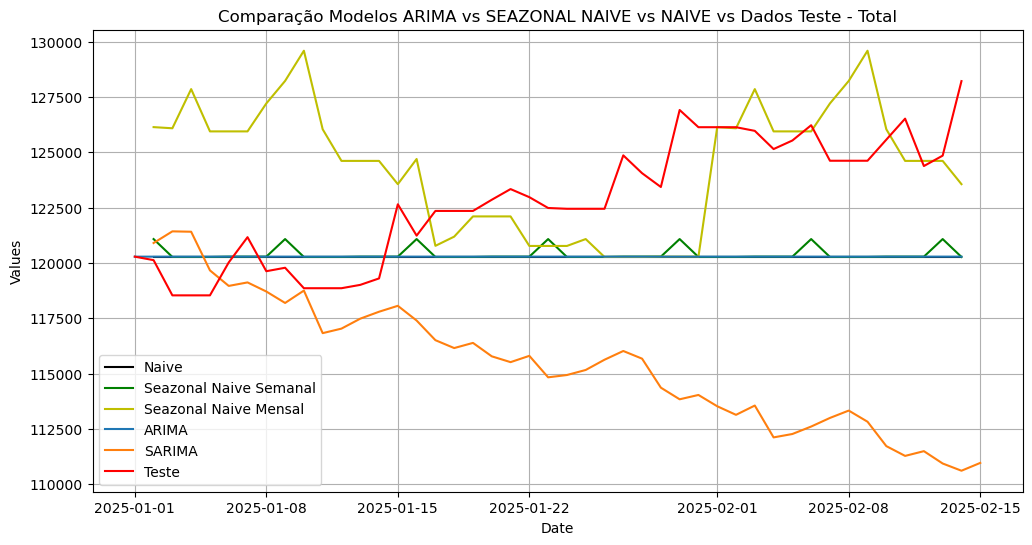

In [ ]:
# Plot the comparison between forecast_series and df_test
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(forecast_df_naive['ds'], forecast_df_naive['Naive'], label='Naive', color='black')
ax.plot(forecast_df_seazonal_naive['ds'], forecast_df_seazonal_naive['SeasonalNaive'], label='Seazonal Naive Semanal', color='g')
ax.plot(forecast_df_seazonal_naive_month['ds'], forecast_df_seazonal_naive_month['SeasonalNaive'], label='Seazonal Naive Mensal', color='y')
ax.plot(df_forecast.index, df_forecast['forecast'], label='ARIMA')
ax.plot(forecast_sarima_mean.index, forecast_sarima_mean, label = 'SARIMA')
ax.plot(df_forecast.index, df_forecast['ibov'], label='Teste', color = 'r')

ax.grid()
ax.set(
    xlabel='Date',
    ylabel='Values',
    title='Comparação Modelos ARIMA vs SEAZONAL NAIVE vs NAIVE vs Dados Teste - Total'
)

ax.legend()

plt.show()

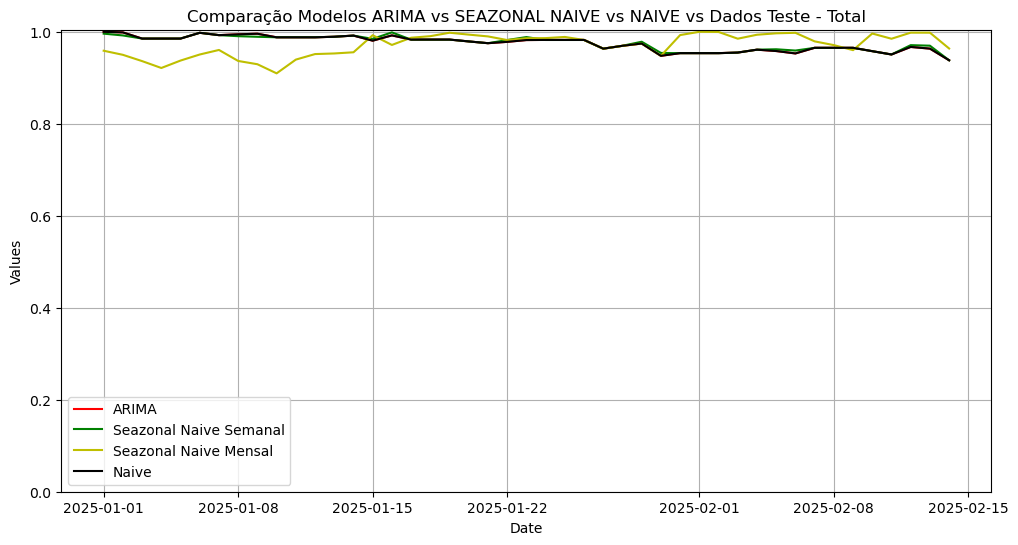

In [ ]:
# Plot the comparison between forecast_series and df_test
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_forecast['data'], df_forecast['precision'], label='ARIMA', color='r')
ax.plot(forecast_df_seazonal_naive['ds'], forecast_df_seazonal_naive['precision'], label='Seazonal Naive Semanal', color='g')
ax.plot(forecast_df_seazonal_naive_month['ds'], forecast_df_seazonal_naive_month['precision'], label='Seazonal Naive Mensal', color='y')
ax.plot(forecast_df_naive['ds'], forecast_df_naive['precision'], label='Naive', color='black')

ax.grid()
ax.set(
    xlabel='Date',
    ylabel='Values',
    title='Comparação Modelos ARIMA vs SEAZONAL NAIVE vs NAIVE vs Dados Teste - Total'
)

ax.set_ylim(ymin=0)

ax.legend()

plt.show()

In [ ]:
print(f"""
ARIMA: {round(df_forecast['precision'].mean(), 3)*100}%
SEAZONAL NAIVE SEMANAL: {round(forecast_df_seazonal_naive['precision'].mean(), 3)*100}%
SEAZONAL NAIVE MENSAL: {round(forecast_df_seazonal_naive_month['precision'].mean(), 3)*100}%
NAIVE: {round(forecast_df_naive['precision'].mean(), 3)*100}%
""")


ARIMA: 97.5%
SEAZONAL NAIVE SEMANAL: 97.6%
SEAZONAL NAIVE MENSAL: 97.1%
NAIVE: 97.5%



In [148]:
# Prediction of daily temperatures
idx = df_test.index
results = pd.DataFrame(
    {
        'Naive': forecast_df_naive['Naive'].loc[forecast_df_naive['ds'] == idx],
        'Arima': df_forecast.forecast,
        'Sarima': sarimax_pred,
        'Teste': df_test['ibov'].loc[idx],
    }
)

fig, ax = plt.subplots(3, 1, figsize=(14, 6))
for i, model in enumerate(['Naive', 'Arima', 'Sarima']):
    results[[model, "Teste"]].plot(ax=ax[i])
    ax[i].legend()
    ax[i].set_title('Predição de Temperatura Diária')
    ax[i].set_xlabel('Data')
    ax[i].set_ylabel('Valor do IBOV')
ax[0].get_figure().set_tight_layout(True)

ValueError: ('Lengths must match to compare', (44,), (45,))